# Figure 2: Compendium of SAMPL-seq longitudinal datasets modeled
This script generates figure 2 of the paper which gives the study designs and stats of the human and mouse studies analyzed in the paper

In [1]:
import numpy as np
import torch
from mcspace.data_utils import get_data, get_mouse_diet_perturbations_dataset, get_human_timeseries_dataset, get_human_inulin_perturbation_dataset
from mcspace.utils import get_device, pickle_load, pickle_save, get_summary_results, MODEL_FILE, DATA_FILE
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from mcspace.dataset import DataSet
import pandas as pd

from matplotlib.colors import ListedColormap

In [2]:
# change font to arial
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['svg.fonttype'] = 'none'

# Paths

Note: Paths are relative to this notebook, which is assumed to be located in `MCSPACE_paper/figures`

In [3]:
basepath = Path("./")
rootpath = Path("../../")

outpath = basepath / "paper_figures"
outpath.mkdir(exist_ok=True, parents=True)

In [4]:
datapath = rootpath / "MCSPACE_paper" / "datasets"

# Load human dataset

In [5]:
reads, num_otus, human_times, human_subjects, dataset = get_human_timeseries_dataset(rootpath=datapath)

temp_taxonomy = dataset.get_taxonomy() 
# updated taxonomy
humanpath = datapath / "human_experiments"
humantax = pd.read_csv(humanpath / "gappa_taxonomy" / "human_taxonomy.csv", index_col=0)
taxonomy = humantax.loc[temp_taxonomy.index,:]

c:\users\gary\documents\projects\mcspace_revisions_8_29_25\mcspace\mcspace\dataset.py:21: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  self._long_data = pd.read_csv(reads)


## compute dataset statistics

In [6]:
def get_particle_read_stats(reads, times, subjects):
    tms = []
    subjs = []
    num_reads = []
    particle_id = []
    
    ptms = []
    psubjs = []
    num_particles = []

    for t in times:
        for s in subjects:
            counts = reads[t][s]
            npart = counts.shape[0]
            nreads_all = counts.sum(axis=1)
            
            ptms.append(t)
            psubjs.append(s)
            num_particles.append(npart)
            
            for lidx in range(npart):
                tms.append(t)
                subjs.append(s)
                particle_id.append(lidx)
                num_reads.append(nreads_all[lidx])
    nreads_df = pd.DataFrame({'Time': tms, 'Subject': subjs, 'Particle': particle_id, 'Number reads': num_reads})
    npart_df = pd.DataFrame({'Time': ptms, 'Subject': psubjs, 'Number particles': num_particles})
    return npart_df, nreads_df


def get_bulk_relative_abundances(reads, times, subjects, taxonomy):
    num_otus = taxonomy.shape[0]
    multiind = pd.MultiIndex.from_frame(taxonomy)
    ntime = len(times)
    
    radfs = {}
    for s in subjects:
        ra = np.zeros((ntime, num_otus))
        for i,t in enumerate(times):
            counts = reads[t][s]
            rabun = counts/counts.sum(axis=1, keepdims=True)
            bulk_rabun = np.mean(rabun, axis=0)
            ra[i,:] = bulk_rabun
        df = pd.DataFrame(data=ra.T, index=multiind, columns=times)
        radfs[s] = df
    return radfs


def filter_taxa(relabund_df):
    CUTOFF_FRAC_ABUNDANCE = 0.01
    # Only keep taxa that have relabund mean exceeding threshold.
    to_keep = relabund_df.loc[relabund_df.mean(axis=1) > CUTOFF_FRAC_ABUNDANCE]
    to_remove = relabund_df.loc[relabund_df.mean(axis=1) <= CUTOFF_FRAC_ABUNDANCE]
    to_keep = to_keep.assign(
        Avg=np.mean(to_keep.values, axis=1)
    ).sort_values('Avg', ascending=False).drop(columns=['Avg'])
    return to_keep.index, to_remove.index


In [7]:
npart_df, nreads_df = get_particle_read_stats(reads, human_times, human_subjects)
humanbulk = get_bulk_relative_abundances(reads, human_times, human_subjects, taxonomy)
grouped = humanbulk['H11'].groupby(level=['Order','Family']).sum()
to_keep, to_remove = filter_taxa(grouped)

# Load inulin study dataset

In [8]:
inulin_reads, inulin_num_otus, inulin_times, inulin_subjects, inulin_dataset = get_human_inulin_perturbation_dataset(rootpath=datapath)
inulin_taxonomy = inulin_dataset.get_taxonomy()

## get data statistics

In [9]:
inulin_npart_df, inulin_nreads_df = get_particle_read_stats(inulin_reads, inulin_times, inulin_subjects)
inulinbulk = get_bulk_relative_abundances(inulin_reads, inulin_times, inulin_subjects, inulin_taxonomy.reset_index())

In [10]:
inulin_grouped = inulinbulk['H11'].groupby(level=['Order','Family']).sum()
inulin_keep, inulin_remove = filter_taxa(inulin_grouped)

# Load mouse dataset

In [11]:
mouse_reads, num_otus, mouse_times, mouse_subjects, mouse_dataset = get_mouse_diet_perturbations_dataset(rootpath=datapath)

temp_taxonomy = mouse_dataset.get_taxonomy() 
# updated taxonomy
mousepath = datapath / "mouse_experiments"
mousetax = pd.read_csv(mousepath / "taxonomy" / "taxonomy.csv", index_col=0)
mouse_taxonomy = mousetax.loc[temp_taxonomy.index,:]

c:\users\gary\documents\projects\mcspace_revisions_8_29_25\mcspace\mcspace\dataset.py:23: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  self._long_data = pd.read_csv(reads, compression='gzip')


## get data statistics

In [12]:
mouse_npart_df, mouse_nreads_df = get_particle_read_stats(mouse_reads, mouse_times, mouse_subjects)
mousebulk = get_bulk_relative_abundances(mouse_reads, mouse_times, mouse_subjects, mouse_taxonomy.reset_index())

### average abundance over subjects

In [13]:
mbulk = mousebulk[mouse_subjects[0]].copy()
for i in range(1,len(mouse_subjects)):
    mbulk = mbulk + mousebulk[mouse_subjects[i]]
    
mouse_ave = mbulk.copy()/len(mouse_subjects)
mouse_grouped =  mouse_ave.groupby(level=['Order','Family']).sum()

In [14]:
mouse_keep, mouse_remove = filter_taxa(mouse_grouped)

# Render figure

In [16]:
def box_to_ell_axes(ax):
    # Hide the right and top spines
    ax.spines[['right', 'top']].set_visible(False)
    return ax 


def plot_relabund(relabund_df, to_keep, to_remove, ax, cmap):
    """
    Plot the relative abundances as a stacked bar chart.
    """
    # Only plot the OTUs that have mean relabund exceeding threshold.
    to_keep = relabund_df.loc[to_keep]
    to_remove = relabund_df.loc[to_remove]
    
    relabund_df = to_keep.assign(
        Avg=np.mean(to_keep.values, axis=1)
    ).sort_values('Avg', ascending=False).drop(columns=['Avg'])
    relabund_df.loc[('Other', 'Other'), :] = to_remove.sum().values

    # Do the plotting.
    relabund_df.T.plot.area(stacked=True, ax=ax, cmap=cmap)
    
    num_t = relabund_df.shape[1]
    num_r = relabund_df.shape[0]

    times = np.asarray(list(relabund_df.columns))
    xlocs = np.arange(0, len(times), step = 10)
    ax.set_xticks(xlocs)
    ax.set_xticklabels(times[xlocs])
    ax.set_ylim([0, 1])
    ax.set_xlim([0, num_t - 1])
    handles, labels = ax.get_legend_handles_labels()
    return ax, handles, labels


def plot_human_timeline(ax):
    times_major = [1,2,3,4,5] 
    minor_ymin = -0.05
    minor_ymax = 0.03
    major_ymin = -0.18
    major_ymax = 0.05

    sample_times = times_major 

    linewidth = 1.5
    ax.vlines(times_major, minor_ymin, minor_ymax, color='black', linewidth=linewidth)
    ax.vlines(times_major, major_ymin, major_ymax, color='black', linewidth=linewidth)
    ax.plot(times_major, np.zeros_like(times_major), color='black', linewidth=linewidth)
    ax.scatter(sample_times, -0.12*np.ones_like(sample_times), s=25, color='black', alpha=0.6, label='fecal sample collection')
    ax.legend(bbox_to_anchor=(1,1), frameon=True, handletextpad=0.1)

    for i,t in enumerate(times_major):
        ax.annotate(f"{t}", (t,-0.3), horizontalalignment='center')
    ax.annotate("Day", (3,-0.45), horizontalalignment='center')
    ax.set_ylim(-0.45, major_ymax+0.05)

    # remove axis and spines
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.spines[["left", "top", "right","bottom"]].set_visible(False)
    return ax


def plot_inulin_timeline(ax, inulin_days=[5, 6, 7, 8], inulin_color='grey', legend=False):
    # Timeline days
    times = np.arange(1,11+1,1)
    # np.array([1, 2, 4, 7, 8, 10, 11])
    times_major = times  # mark all days as major for this small set
    
    minor_ymin = -0.05
    minor_ymax = 0.03
    major_ymin = -0.18
    major_ymax = 0.05

    # Example sample times (adjust as needed)
    sample_times = [1, 2, 4, 7, 8, 10, 11]

    linewidth = 1.5
    ax.vlines(times, minor_ymin, minor_ymax, color='black', linewidth=linewidth)
    ax.vlines(times_major, major_ymin, major_ymax, color='black', linewidth=linewidth)
    ax.plot(times, np.zeros_like(times), color='black', linewidth=linewidth)
    ax.scatter(sample_times, -0.12*np.ones_like(sample_times), s=25, color='black', alpha=0.6, label='Sample')
    
    if legend:
        ax.legend(bbox_to_anchor=(1.0, 0.65), frameon=True, handletextpad=0.1)

    # Annotate days
    for t in times_major:
        ax.annotate(f"{t}", (t, -0.3), horizontalalignment='center')
    ax.annotate("Day", (np.mean(times), -0.45), horizontalalignment='center')

    # Inulin perturbation: draw thick line across day 7 and 8
    inulin_range = [min(inulin_days), max(inulin_days)]
    ax.plot(inulin_range, [0, 0], linewidth=10, alpha=0.5, color=inulin_color)
    ax.annotate("Inulin", (np.mean(inulin_range), major_ymax + 0.05), 
                horizontalalignment='center', color='k')

    ax.set_ylim(-0.45, major_ymax + 0.1)

    # Clean axis
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.spines[["left", "top", "right", "bottom"]].set_visible(False)

    return ax


def plot_mouse_timeline(ax, pcolors=['grey', 'grey', 'grey'], legend=False):
    times = np.arange(0,77,2)
    times_major = np.arange(0,77,10)
    minor_ymin = -0.05
    minor_ymax = 0.03
    major_ymin = -0.18
    major_ymax = 0.05

    sample_times = [10,18,35,43,57,65,76]
    HFD = np.array([10+1.5 + 0.1, 19-0.5])
    Pectin = np.array([35+1.5, 44-0.5])
    LP = np.array([57+1.5,66-0.5])
    perts = [HFD, Pectin, LP]

    linewidth = 1.5
    ax.vlines(times, minor_ymin, minor_ymax, color='black', linewidth=linewidth)
    ax.vlines(times_major, major_ymin, major_ymax, color='black', linewidth=linewidth)
    ax.plot(times, np.zeros_like(times), color='black', linewidth=linewidth)
    ax.scatter(sample_times, -0.12*np.ones_like(sample_times), s=25, color='black', alpha=0.6, label='SAMPL-seq\nsample')
    if legend:
        ax.legend(bbox_to_anchor=(0.97,0.65), frameon=True, handletextpad=0.1)

    for i,t in enumerate(times_major):
        ax.annotate(f"{t}", (t,-0.3), horizontalalignment='center')
    ax.annotate("Day", (39,-0.45), horizontalalignment='center')
    
    # perturbations
    lwidth = 10
    pnames = ['High fat\n(HF)', 'High fat,\nhigh fiber\n(HFHF)', 'Low protein\n(LP)']
    for pert, pcolor, pname in zip(perts, pcolors, pnames):
        ax.plot(pert, np.zeros_like(pert), linewidth=lwidth, alpha=0.5, color=pcolor)
        ax.annotate(pname, (np.mean(pert), major_ymax+0.05), horizontalalignment='center')
    # standard diets
    snames = ['S1', 'S2', 'S3', 'S4']
    std_xpos = [6,29,51,72]
    for xp, s in zip(std_xpos, snames):
        ax.annotate(s, (xp, major_ymax+0.03), horizontalalignment='center')
    ax.set_ylim(-0.45, major_ymax+0.05)

    # remove axis and spines
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.spines[["left", "top", "right","bottom"]].set_visible(False)
    return ax


def format_labels(labels):
    newlabs = []
    for label in labels:
        order, fam = label[1:-1].split(', ')
        if fam == 'na':
            fam = '(not resolved to family)'
        name = order + ', ' + fam #f'$\it{fam}$'
        if order == 'na':
            order = '(not resolved to order)'
            name = order
        if order == 'Other':
            name = '(below 1%)'
        newlabs.append(name)
    return newlabs

## get colormaps

In [17]:
def get_trimmed_relabund(relabund_df, to_keep, to_remove):
    """
    Plot the relative abundances as a stacked bar chart.
    """
    # Only plot the OTUs that have mean relabund exceeding threshold.
    to_keep = relabund_df.loc[to_keep]
    to_remove = relabund_df.loc[to_remove]
    
    relabund_df = to_keep.assign(
        Avg=np.mean(to_keep.values, axis=1)
    ).sort_values('Avg', ascending=False).drop(columns=['Avg'])
    relabund_df.loc[('Other', 'Other'), :] = to_remove.sum().values
    
    return relabund_df


def plot_relabund2(relabund_df, ax, cmap_dict):
    """
    Plot the relative abundances as a stacked bar chart.
    """

    relabund_df.T.plot.area(stacked=True, ax=ax, color=cmap_dict)
    
    num_t = relabund_df.shape[1]
    num_r = relabund_df.shape[0]

    times = np.asarray(list(relabund_df.columns))
    xlocs = np.arange(0, len(times), step = 10)
    ax.set_xticks(xlocs)
    ax.set_xticklabels(times[xlocs])
    ax.set_ylim([0, 1])
    ax.set_xlim([0, num_t - 1])
    handles, labels = ax.get_legend_handles_labels()
    return ax, handles, labels

In [18]:
grouped_trimmed = get_trimmed_relabund(grouped, to_keep, to_remove)
inulin_grouped_trimmed = get_trimmed_relabund(inulin_grouped, inulin_keep, inulin_remove)
mouse_grouped_trimmed = get_trimmed_relabund(mouse_grouped, mouse_keep, mouse_remove)

### fix naming conflicts

In [20]:
for df in [grouped_trimmed, inulin_grouped_trimmed, mouse_grouped_trimmed]:
    df.index = df.index.map(
        lambda x: ('Clostridiales', 'Ruminococcaceae') if x == ('Oscillospirales', 'Ruminococcaceae')
        else ('Lachnospirales', 'Lachnospiraceae') if x == ('Clostridiales', 'Lachnospiraceae')
        else x
    )

In [23]:
all_indices = list(set(grouped_trimmed.index).union(set(inulin_grouped_trimmed.index)).union(set(mouse_grouped_trimmed.index)))
print(len(all_indices))

26


In [24]:
colors = np.concatenate([sns.color_palette("hls", n_colors=10), sns.color_palette("dark", n_colors=10), sns.color_palette('pastel', n_colors=10)])
cmap_human = ListedColormap(colors)

cmap_dict = {}
for (i, (order, family)) in enumerate(all_indices):
    color = cmap_human.colors[i % len(cmap_human.colors)]
    cmap_dict[(order, family)] = color

# Plot figure

In [25]:
clr = 'steelblue'
spalette = 'dark:steelblue'
mouse_diets = ['S1', 'HF', 'S2', 'HFHF', 'S3', 'LP', 'S4']

label_y = 1.1

label_x = -0.2
label_x4 = -0.25

label_x2 = -0.31
label_x3 = -0.21
fontsize=12
label_fontsize=14

alpha=0.7
scale = 1.5

C:\Users\Gary\AppData\Local\Temp\ipykernel_444100\1343598446.py:146: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_mreads.set_xticklabels(mouse_diets)
C:\Users\Gary\AppData\Local\Temp\ipykernel_444100\1343598446.py:169: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_mpart.set_xticklabels(mouse_diets)


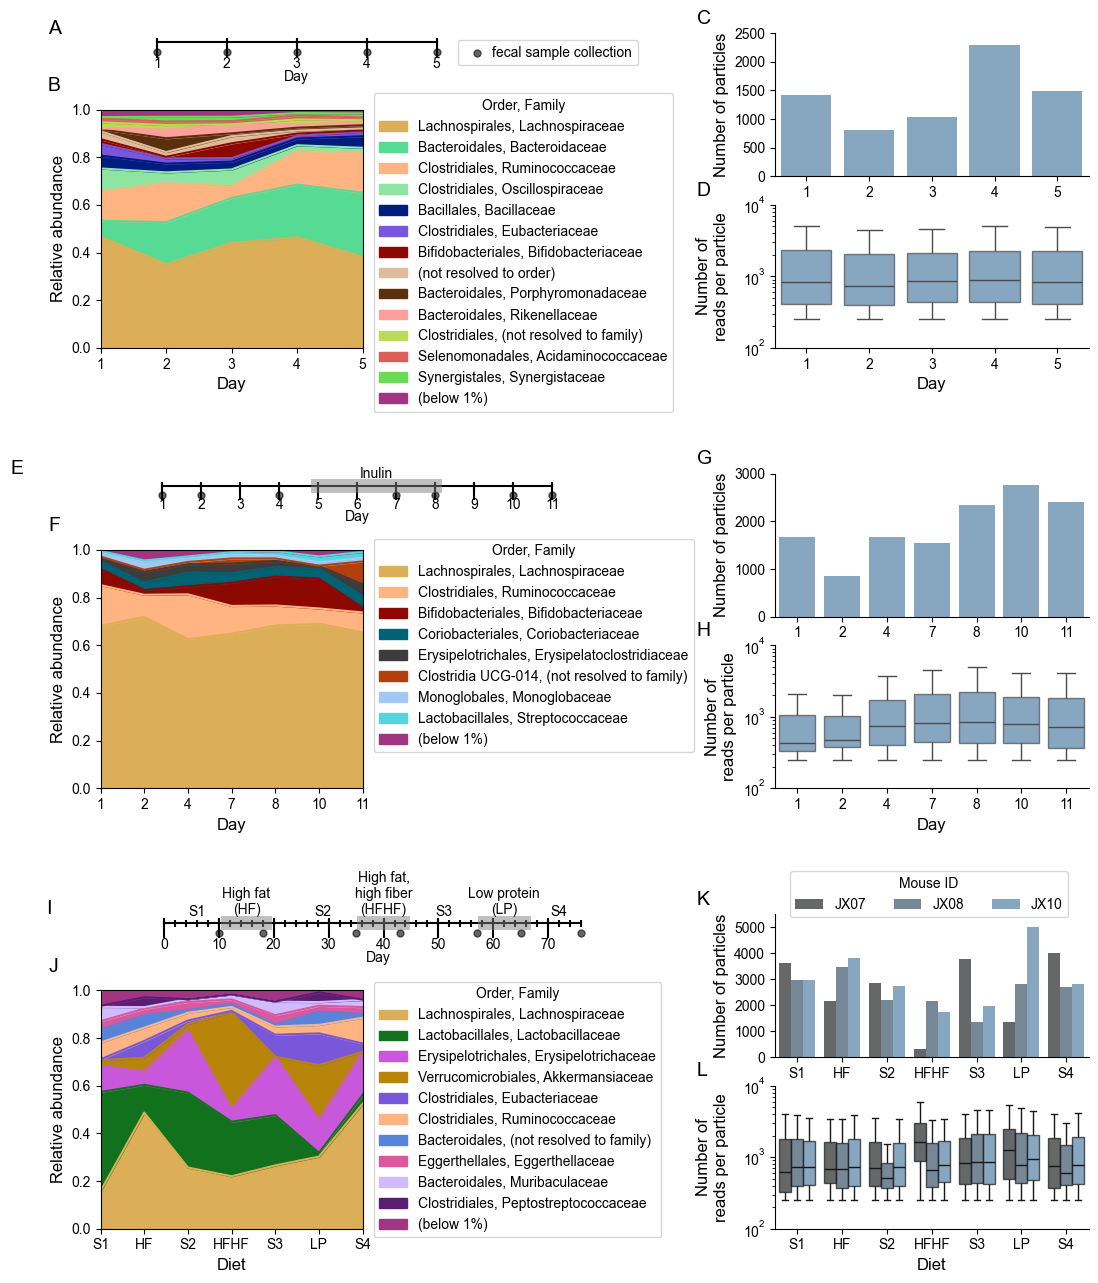

In [27]:
fig = plt.figure(figsize=(8.5*scale,0.9*11.5*scale))
gs = fig.add_gridspec(nrows=3,ncols=2,
                      width_ratios=[2,1],
                    wspace=0.1,
                     hspace=0.4)

# HUMAN DATA
# -----------------------------------------------------------------
# create columns
gs_hstats = gs[0,1].subgridspec(2,1)
ax_hreads = fig.add_subplot(gs_hstats[1,0])
ax_hpart = fig.add_subplot(gs_hstats[0,0])

gs_hra = gs[0,0].subgridspec(2,4, height_ratios=[1,5], width_ratios=[0.05,0.725,0.2,0.825])
ax_htime = fig.add_subplot(gs_hra[0,1:3])
ax_hra = fig.add_subplot(gs_hra[1,:2])

# plot stats
ax_hreads=sns.boxplot(data=nreads_df, x='Time', y='Number reads', ax=ax_hreads, 
                      showfliers=False, color=clr, boxprops={'alpha': alpha})
ax_hreads=box_to_ell_axes(ax_hreads)
ax_hreads.set_ylim(100,1e4)
ax_hreads.set_yscale('log')
ax_hreads.set_xlabel("Day", fontsize=fontsize)
ax_hreads.set_ylabel("Number of\nreads per particle", fontsize=fontsize)

# ax_hreads.set_axisbelow(True)
# ax_hreads.yaxis.grid(True, 'major', linewidth=1, color='#e6e6e6')

ax_hreads.text(label_x4, label_y, 'D', horizontalalignment='left',verticalalignment='center', 
             transform=ax_hreads.transAxes, fontsize=label_fontsize)


ax_hpart=sns.barplot(data=npart_df, x='Time', y='Number particles', 
                     ax=ax_hpart, color=clr, alpha=alpha)
ax_hpart=box_to_ell_axes(ax_hpart)
ax_hpart.set_xlabel("")
# ax_hpart.set_ylim(0, np.amax(npart_df['Number particles'])*1.1)
ax_hpart.set_ylim(0,2500)
ax_hpart.set_ylabel("Number of particles", fontsize=fontsize)
# ax_hpart.set_axisbelow(True)
# ax_hpart.yaxis.grid(True, 'major', linewidth=1, color='#e6e6e6')

ax_hpart.text(label_x4, label_y, 'C', horizontalalignment='left',verticalalignment='center', 
             transform=ax_hpart.transAxes, fontsize=label_fontsize)

# plot timeline
ax_htime = plot_human_timeline(ax_htime)
ax_htime.text(label_x2, label_y, 'A', horizontalalignment='left',verticalalignment='center', 
             transform=ax_htime.transAxes, fontsize=label_fontsize)

# plot abundances
ax_hra, handles, labels = plot_relabund2(grouped_trimmed, ax_hra, cmap_dict)
ax_hra.set_ylabel("Relative abundance", fontsize=fontsize)
ax_hra.set_xticks(np.array(human_times) - 1)
ax_hra.set_xticklabels(human_times)
ax_hra.set_xlabel("Day", fontsize=fontsize)
 
# ax_hra.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1.0, 0.45))
labels = format_labels(labels)
ax_hra.legend(handles, labels, loc='center left', bbox_to_anchor=(1.015, 0.4), title='Order, Family')
ax_hra.text(label_x, label_y, 'B', horizontalalignment='left',verticalalignment='center', 
             transform=ax_hra.transAxes, fontsize=label_fontsize)





# HUMAN INULIN PERTURBED DATA
# -----------------------------------------------------------------
# create columns
gs_istats = gs[1,1].subgridspec(2,1)
ax_ireads = fig.add_subplot(gs_istats[1,0])
ax_ipart = fig.add_subplot(gs_istats[0,0])

gs_ira = gs[1,0].subgridspec(2,4, height_ratios=[1,5], width_ratios=[0.05,0.725,0.6,0.425])
ax_itime = fig.add_subplot(gs_ira[0,1:3])
ax_ira = fig.add_subplot(gs_ira[1,:2])


# plot stats
ax_ireads=sns.boxplot(data=inulin_nreads_df, x='Time', y='Number reads', ax=ax_ireads, 
                      showfliers=False, color=clr, boxprops={'alpha': alpha})
ax_ireads=box_to_ell_axes(ax_ireads)
ax_ireads.set_ylim(100,1e4)
ax_ireads.set_yscale('log')
ax_ireads.set_xlabel("Day", fontsize=fontsize)
ax_ireads.set_ylabel("Number of\nreads per particle", fontsize=fontsize)

# ax_hreads.set_axisbelow(True)
# ax_hreads.yaxis.grid(True, 'major', linewidth=1, color='#e6e6e6')

ax_ireads.text(label_x4, label_y, 'H', horizontalalignment='left',verticalalignment='center', 
             transform=ax_ireads.transAxes, fontsize=label_fontsize)


ax_ipart=sns.barplot(data=inulin_npart_df, x='Time', y='Number particles', 
                     ax=ax_ipart, color=clr, alpha=alpha)
ax_ipart=box_to_ell_axes(ax_ipart)
ax_ipart.set_xlabel("")
# ax_hpart.set_ylim(0, np.amax(npart_df['Number particles'])*1.1)
ax_ipart.set_ylim(0,3000)
ax_ipart.set_ylabel("Number of particles", fontsize=fontsize)
ax_ipart.text(label_x4, label_y, 'G', horizontalalignment='left',verticalalignment='center', 
             transform=ax_ipart.transAxes, fontsize=label_fontsize)


# plot timeline
ax_itime = plot_inulin_timeline(ax_itime)
ax_itime.text(label_x2, label_y, 'E', horizontalalignment='left',verticalalignment='center', 
             transform=ax_itime.transAxes, fontsize=label_fontsize)

# plot abundances
ax_ira, handles, labels = plot_relabund2(inulin_grouped_trimmed, ax_ira, cmap_dict)
ax_ira.set_ylabel("Relative abundance", fontsize=fontsize)
ax_ira.set_xticks(np.arange(len(inulin_times)))
ax_ira.set_xticklabels(inulin_times)
ax_ira.set_xlabel("Day", fontsize=fontsize)
 
# ax_hra.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1.0, 0.45))
labels = format_labels(labels)
ax_ira.legend(handles, labels, loc='center left', bbox_to_anchor=(1.015, 0.6), title='Order, Family')
ax_ira.text(label_x, label_y, 'F', horizontalalignment='left',verticalalignment='center', 
             transform=ax_ira.transAxes, fontsize=label_fontsize)





# MOUSE DATA
# -----------------------------------------------------------------
# create columns
gs_mstats = gs[2,1].subgridspec(2,1)
ax_mreads = fig.add_subplot(gs_mstats[1,0])
ax_mpart = fig.add_subplot(gs_mstats[0,0])

gs_mra = gs[2,0].subgridspec(2,4, height_ratios=[1,5], width_ratios=[0.05,0.725,0.7,0.325])
ax_mtime = fig.add_subplot(gs_mra[0,1:3])
ax_mra = fig.add_subplot(gs_mra[1,0:2])

# plot stats
ax_mreads=sns.boxplot(data=mouse_nreads_df, x='Time', y='Number reads', hue='Subject', ax=ax_mreads, 
                      showfliers=False, palette=spalette, boxprops={'alpha': alpha})
ax_mreads=box_to_ell_axes(ax_mreads)
ax_mreads.set_ylabel("Number of\nreads per particle", fontsize=fontsize)
ax_mreads.set_xticklabels(mouse_diets)
ax_mreads.set_ylim(100,1e4)
ax_mreads.set_yscale('log')
# ax_mreads.set_axisbelow(True)
# ax_mreads.yaxis.grid(True, 'major', linewidth=1, color='#e6e6e6')
ax_mreads.get_legend().remove()
# ax_mreads.legend(title='Subject', bbox_to_anchor=(0.8,0.75))

ax_mreads.text(label_x4, label_y, 'L', horizontalalignment='left',verticalalignment='center', 
             transform=ax_mreads.transAxes, fontsize=label_fontsize)
ax_mreads.set_xlabel("Diet", fontsize=fontsize)


ax_mpart=sns.barplot(data=mouse_npart_df, x='Time', y='Number particles', hue='Subject',
                     ax=ax_mpart, palette=spalette, alpha=alpha)
ax_mpart=box_to_ell_axes(ax_mpart)
ax_mpart.set_ylim(0,5500)
ax_mpart.set_yticks(np.arange(0,5500,1000))
# ax_mpart.set_axisbelow(True)
# ax_mpart.yaxis.grid(True, 'major', linewidth=1, color='#e6e6e6')
ax_mpart.set_xlabel("")
ax_mpart.set_ylabel("Number of particles", fontsize=fontsize)

ax_mpart.set_xticklabels(mouse_diets)

ax_mpart.legend(title='Mouse ID', loc='upper left', bbox_to_anchor=(0.025,1.35), ncols=3)
# ax_mpart.set_yscale('log')
ax_mpart.text(label_x4, label_y, 'K', horizontalalignment='left',verticalalignment='center', 
             transform=ax_mpart.transAxes, fontsize=label_fontsize)

# plot timeline
ax_mtime = plot_mouse_timeline(ax_mtime) #, pcolors=pcolors)
ax_mtime.text(label_x3, label_y, 'I', horizontalalignment='left',verticalalignment='center', 
             transform=ax_mtime.transAxes, fontsize=label_fontsize)

# plot abundances
ax_mra, handles, labels = plot_relabund2(mouse_grouped_trimmed, ax_mra, cmap_dict)
ax_mra.set_ylabel("Relative abundance", fontsize=fontsize)
ax_mra.set_xticks(np.arange(len(mouse_times)))
ax_mra.set_xticklabels(mouse_diets)
ax_mra.set_xlabel("Diet", fontsize=fontsize)
 
labels = format_labels(labels)
# ax_mra.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1.0, 0.45))
ax_mra.legend(handles, labels, loc='center left', bbox_to_anchor=(1.015, 0.5), title='Order, Family')
ax_mra.text(label_x, label_y, 'J', horizontalalignment='left',verticalalignment='center', 
             transform=ax_mra.transAxes, fontsize=label_fontsize)


fig.align_ylabels([ax_hreads, ax_hpart, ax_mreads, ax_mpart])
fig.align_ylabels([ax_hra, ax_mra])


plt.savefig(outpath / "figure2_datasets.svg", bbox_inches="tight")